In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import copy
import math
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
from lightly.loss import DINOLoss
from lightly.models.modules import DINOProjectionHead
from lightly.models.utils import deactivate_requires_grad, update_momentum
from lightly.transforms.dino_transform import DINOTransform
from lightly.utils.scheduler import cosine_schedule
import torchvision
from torchvision.models import resnet18,efficientnet_b0
from torchvision import datasets, transforms
import torch.nn as nn
from copy import deepcopy
from torchvision import datasets, transforms
from astra.torch.metrics import f1_score,precision_score,recall_score
from astra.torch.utils import train_fn
from torch.utils.data import DataLoader, Dataset, TensorDataset
from tqdm import tqdm,trange
import pandas as pd
from lightly.loss import NegativeCosineSimilarity
from lightly.models.modules.heads import SimSiamPredictionHead, SimSiamProjectionHead
from lightly.transforms import SimCLRTransform, utils
from lightly.data import LightlyDataset
from lightly.transforms import SimSiamTransform
from torchvision.transforms import ToPILImage

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# path to all models and data
path = "/home/vannsh.jani/brick_kilns/ssl_exp"
# inside this folder there are various folders for different models and data

In [4]:
x_train = torch.load(f"{path}/data/ban_x_train_50.pt") # 50% Bangladesh
y_train = torch.load(f"{path}/data/ban_y_train_50.pt")

In [5]:
x_test = torch.load(f"{path}/data/delhi.pt")  # 100% Delhi
y_test = torch.load(f"{path}/data/delhi_new_labels.pt")

In [6]:
from sklearn.model_selection import train_test_split
x_del,x_test,y_del,y_test = train_test_split(x_test,y_test,test_size=0.5,random_state=42,stratify=y_test)

In [7]:
x_del.shape,x_test.shape

(torch.Size([5012, 3, 224, 224]), torch.Size([5013, 3, 224, 224]))

In [8]:
x_del_to_use,_,y_del_to_use,_ = train_test_split(x_del,y_del,test_size=0.9,random_state=42,stratify=y_del)

In [9]:
x_del_to_use.shape

torch.Size([501, 3, 224, 224])

In [10]:
x_train_new = torch.cat([x_train,x_del_to_use],dim=0)
y_train_new = torch.cat([y_train,y_del_to_use],dim=0)

In [11]:
x_train_new.shape,y_train_new.shape

(torch.Size([13250, 3, 224, 224]), torch.Size([13250]))

In [14]:
save_path = "/tmp"
os.makedirs(f"{save_path}/data",exist_ok=True)
torch.save(x_test,f"{save_path}/data/delhi_test_images_50.pt")
torch.save(y_test,f"{save_path}/data/delhi_test_labels_50.pt")
torch.save(x_del_to_use,f"{save_path}/data/delhi_5_images.pt")
torch.save(y_del_to_use,f"{save_path}/data/delhi_5_labels.pt")

In [15]:
x_del_to_use = torch.load(f"{path}/data/delhi_5_images.pt")
y_del_to_use = torch.load(f"{path}/data/delhi_5_labels.pt")
x_test = torch.load(f"{path}/data/delhi_test_images_50.pt")  
y_test = torch.load(f"{path}/data/delhi_test_labels_50.pt")

In [6]:
x_train_new = torch.cat([x_train,x_del_to_use],dim=0)
y_train_new = torch.cat([y_train,y_del_to_use],dim=0)

In [7]:
len(y_test[y_test==1])

521

In [10]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

(torch.Size([12749, 3, 224, 224]),
 torch.Size([12749]),
 torch.Size([10025, 3, 224, 224]),
 torch.Size([10025]))

In [8]:
# Downstream model
eff = torchvision.models.efficientnet_b0(pretrained=False)
class DownstreamModel(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.eff = nn.Sequential(*list(eff.children())[:-1])
        self.eff.load_state_dict(torch.load("/home/vannsh.jani/brick_kilns/ssl_exp/byol/byol_bd_150.pth")) # load different weights
        self.fc = nn.Linear(1280,num_classes)

    def forward(self, x):
        x = self.eff(x).flatten(start_dim=1)
        return self.fc(x)

/home/vannsh.jani/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vannsh.jani/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [9]:
classifier = DownstreamModel(2).to(device)

In [ ]:
## Imagenet model
model1 = efficientnet_b0(pretrained=True)
model1.classifier[1] = nn.Linear(1280, 2)
model1.to(device)


In [11]:
def get_metrics(y_pred,y_label):
    with torch.no_grad():
        f1 = f1_score(y_pred,y_label)
        precision = precision_score(y_pred,y_label)
        recall = recall_score(y_pred,y_label)
        return f1,precision,recall

In [12]:
# train function, # save data every k epochs
def train(model, X_train, y_train, criterion, epochs, lr, verbose,model_name,data="delhi_test",k=10, batch_size=256): # model name for saving different models 
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    model.to(device)
    epoch_losses = []
    f1_list = []
    precision_list = []
    recall_list = []
    epoch_k_loss = []
    # train_dataset = TensorDataset(X_train, y_train)
    # train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    X_train = X_train.float()
    for epoch in trange(epochs, desc="Epochs"):
        batch_losses = []  # Track losses per batch
        y_total_pred = []
        for i in trange(0, len(X_train), batch_size):
            optimizer.zero_grad()
            X_batch = X_train[i:i+batch_size].to(device)
            y_batch = y_train[i:i+batch_size].to(device)
            y_pred = model(X_batch).to(device)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
            y_total_pred.append(y_pred)

        # Calculate average loss for the epoch
        epoch_loss = sum(batch_losses) / len(batch_losses)
        epoch_losses.append(epoch_loss)
        with torch.no_grad():
                f,p,r = get_metrics(torch.cat(y_total_pred).argmax(dim=1).cpu(),y_train.cpu())
                f1_list.append(f)
                precision_list.append(p)
                recall_list.append(r)
        
        if verbose:
            print(f"Epoch: {epoch} Loss: {epoch_loss}")
        if (epoch+1)%k == 0 or epoch ==epochs-1:
            epoch_k_loss.append(epoch_loss)
            torch.save(model.state_dict(),f"{path}/{model_name}/{epoch+1}_{data}_final_table.pth")
           
            


    return epoch_losses,f1_list,precision_list,recall_list,epoch_k_loss


In [13]:
# testing function

def predict(model,X_test,y_test,criterion,batch_size = 32):
    result_dict = {}
    X_test = X_test.float()
    test_loss = []
    with torch.no_grad():
        model.eval()
        # incorporating batch size
        test_dataset = TensorDataset(X_test, y_test)
        test_loader = DataLoader(test_dataset, batch_size=batch_size)
        y_pred = []
        for x, y in tqdm(test_loader):
            x = x.to(device)
            y = y.to(device)
            output = model(x)
            loss = criterion(output,y.long())
            y_pred.append(output)
            test_loss.append(loss)
        y_pred = torch.cat(y_pred)
        # print(y_pred)
        y_pred = torch.argmax(y_pred,dim=1)
        # print(y_pred)
        y_pred = y_pred.cpu()
        y_test = y_test.cpu()
        # print(y_pred.dtype,y_test.dtype)
        f1,precision,recall = get_metrics(y_pred,y_test)

        avg_loss = sum(test_loss)/len(test_loss)
        result_dict = {"f1":f1.item(),"precision":precision.item(),"recall":recall.item(),"loss":avg_loss}
        return result_dict


In [14]:
# no ssl training is required, only finetuning left, for which we can load weights into downstream model
# and use train and test functions to get results

In [15]:
y_train_new = y_train_new.long()

In [15]:
epoch_losses,f1_list,precision_list,recall_list,epoch_k_loss = train(classifier,x_train,y_train,nn.CrossEntropyLoss(),75,0.001,True,"byol",data="delhi_test_train5_exp",k=5)

Epochs:   1%|▏         | 1/75 [00:15<19:18, 15.65s/it]

Epoch: 0 Loss: 0.10616724057123066


Epochs:   3%|▎         | 2/75 [00:30<18:37, 15.30s/it]

Epoch: 1 Loss: 0.03527568772900849


Epochs:   4%|▍         | 3/75 [00:44<17:27, 14.56s/it]

Epoch: 2 Loss: 0.018507709950208662


Epochs:   5%|▌         | 4/75 [00:58<16:51, 14.24s/it]

Epoch: 3 Loss: 0.014316304174717515


Epochs:   7%|▋         | 5/75 [01:11<16:14, 13.92s/it]

Epoch: 4 Loss: 0.01390311103546992


Epochs:   8%|▊         | 6/75 [01:25<15:51, 13.78s/it]

Epoch: 5 Loss: 0.014811797102447599


Epochs:   9%|▉         | 7/75 [01:38<15:33, 13.72s/it]

Epoch: 6 Loss: 0.007180036882054992


Epochs:  11%|█         | 8/75 [01:52<15:21, 13.76s/it]

Epoch: 7 Loss: 0.00529816410766216


Epochs:  12%|█▏        | 9/75 [02:05<15:03, 13.69s/it]

Epoch: 8 Loss: 0.006146283690759447


Epochs:  13%|█▎        | 10/75 [02:18<14:19, 13.23s/it]

Epoch: 9 Loss: 0.0077441536606056615


Epochs:  15%|█▍        | 11/75 [02:31<14:12, 13.32s/it]

Epoch: 10 Loss: 0.007099194586771773


Epochs:  16%|█▌        | 12/75 [02:43<13:35, 12.95s/it]

Epoch: 11 Loss: 0.004406730420596432


Epochs:  17%|█▋        | 13/75 [02:57<13:35, 13.15s/it]

Epoch: 12 Loss: 0.0040831725756288505


Epochs:  19%|█▊        | 14/75 [03:11<13:32, 13.32s/it]

Epoch: 13 Loss: 0.002917637036007363


Epochs:  20%|██        | 15/75 [03:24<13:25, 13.42s/it]

Epoch: 14 Loss: 0.005467219825659413


Epochs:  21%|██▏       | 16/75 [03:38<13:12, 13.44s/it]

Epoch: 15 Loss: 0.0031450094746833203


Epochs:  23%|██▎       | 17/75 [03:51<13:01, 13.47s/it]

Epoch: 16 Loss: 0.0019086389612857602


Epochs:  24%|██▍       | 18/75 [04:05<12:49, 13.49s/it]

Epoch: 17 Loss: 0.0011219781552063068


Epochs:  25%|██▌       | 19/75 [04:18<12:36, 13.51s/it]

Epoch: 18 Loss: 0.0026835272810603783


Epochs:  27%|██▋       | 20/75 [04:32<12:24, 13.54s/it]

Epoch: 19 Loss: 0.002424116351903649


Epochs:  28%|██▊       | 21/75 [04:46<12:12, 13.56s/it]

Epoch: 20 Loss: 0.0022377315558696864


Epochs:  29%|██▉       | 22/75 [04:59<12:02, 13.63s/it]

Epoch: 21 Loss: 0.0026380296158095007


Epochs:  31%|███       | 23/75 [05:13<11:42, 13.50s/it]

Epoch: 22 Loss: 0.0035780549302580765


Epochs:  32%|███▏      | 24/75 [05:26<11:28, 13.51s/it]

Epoch: 23 Loss: 0.002336688060386223


Epochs:  33%|███▎      | 25/75 [05:40<11:15, 13.52s/it]

Epoch: 24 Loss: 0.002630991023106617


Epochs:  35%|███▍      | 26/75 [05:52<10:42, 13.11s/it]

Epoch: 25 Loss: 0.002460813494544709


Epochs:  36%|███▌      | 27/75 [06:05<10:35, 13.23s/it]

Epoch: 26 Loss: 0.0014260008482233388


Epochs:  37%|███▋      | 28/75 [06:19<10:25, 13.31s/it]

Epoch: 27 Loss: 0.0023548655485501513


Epochs:  39%|███▊      | 29/75 [06:32<10:14, 13.36s/it]

Epoch: 28 Loss: 0.0013666521815684973


Epochs:  40%|████      | 30/75 [06:46<10:02, 13.38s/it]

Epoch: 29 Loss: 0.0016585794270577027


Epochs:  41%|████▏     | 31/75 [06:59<09:50, 13.41s/it]

Epoch: 30 Loss: 0.0037008079392035144


Epochs:  43%|████▎     | 32/75 [07:13<09:37, 13.43s/it]

Epoch: 31 Loss: 0.005332050330616766


Epochs:  44%|████▍     | 33/75 [07:26<09:24, 13.44s/it]

Epoch: 32 Loss: 0.0012460161548733595


Epochs:  45%|████▌     | 34/75 [07:40<09:13, 13.51s/it]

Epoch: 33 Loss: 0.001467048035847256


Epochs:  47%|████▋     | 35/75 [07:55<09:20, 14.01s/it]

Epoch: 34 Loss: 0.0013085004844833748


Epochs:  48%|████▊     | 36/75 [08:09<09:04, 13.95s/it]

Epoch: 35 Loss: 0.00035317367626703345


Epochs:  49%|████▉     | 37/75 [08:21<08:31, 13.46s/it]

Epoch: 36 Loss: 9.583973172084371e-05


Epochs:  51%|█████     | 38/75 [08:35<08:24, 13.65s/it]

Epoch: 37 Loss: 4.796754075869103e-05


Epochs:  52%|█████▏    | 39/75 [08:50<08:19, 13.88s/it]

Epoch: 38 Loss: 0.0004726217450115655


Epochs:  53%|█████▎    | 40/75 [09:02<07:54, 13.55s/it]

Epoch: 39 Loss: 0.002020907009500661


Epochs:  55%|█████▍    | 41/75 [09:15<07:32, 13.32s/it]

Epoch: 40 Loss: 0.006641360638750485


Epochs:  56%|█████▌    | 42/75 [09:28<07:11, 13.08s/it]

Epoch: 41 Loss: 0.002116073612560285


Epochs:  57%|█████▋    | 43/75 [09:41<06:57, 13.06s/it]

Epoch: 42 Loss: 0.001976195835341059


Epochs:  59%|█████▊    | 44/75 [09:53<06:35, 12.76s/it]

Epoch: 43 Loss: 0.0020063877359280014


Epochs:  60%|██████    | 45/75 [10:05<06:20, 12.69s/it]

Epoch: 44 Loss: 0.001478051492904342


Epochs:  61%|██████▏   | 46/75 [10:18<06:09, 12.75s/it]

Epoch: 45 Loss: 0.0009935092776322562


Epochs:  63%|██████▎   | 47/75 [10:30<05:52, 12.59s/it]

Epoch: 46 Loss: 0.0008629404596467794


Epochs:  64%|██████▍   | 48/75 [10:44<05:47, 12.86s/it]

Epoch: 47 Loss: 8.470920024592488e-05


Epochs:  65%|██████▌   | 49/75 [10:57<05:39, 13.04s/it]

Epoch: 48 Loss: 0.00019837969782656728


Epochs:  67%|██████▋   | 50/75 [11:09<05:18, 12.76s/it]

Epoch: 49 Loss: 0.00010552723850651091


Epochs:  68%|██████▊   | 51/75 [11:23<05:09, 12.91s/it]

Epoch: 50 Loss: 1.3522097065106209e-05


Epochs:  69%|██████▉   | 52/75 [11:35<04:52, 12.71s/it]

Epoch: 51 Loss: 1.71083804934824e-05


Epochs:  71%|███████   | 53/75 [11:47<04:35, 12.54s/it]

Epoch: 52 Loss: 9.585266476733523e-05


Epochs:  72%|███████▏  | 54/75 [12:00<04:25, 12.65s/it]

Epoch: 53 Loss: 0.00011636016023885531


Epochs:  73%|███████▎  | 55/75 [12:13<04:12, 12.63s/it]

Epoch: 54 Loss: 9.808843418113611e-05


Epochs:  75%|███████▍  | 56/75 [12:25<03:56, 12.45s/it]

Epoch: 55 Loss: 0.00010624126383845578


Epochs:  76%|███████▌  | 57/75 [12:37<03:45, 12.53s/it]

Epoch: 56 Loss: 0.0012119884724120311


Epochs:  77%|███████▋  | 58/75 [12:50<03:34, 12.61s/it]

Epoch: 57 Loss: 0.0017627629542812428


Epochs:  79%|███████▊  | 59/75 [13:02<03:19, 12.45s/it]

Epoch: 58 Loss: 0.003920010498222837


Epochs:  80%|████████  | 60/75 [13:16<03:11, 12.78s/it]

Epoch: 59 Loss: 0.0049001090916135585


Epochs:  81%|████████▏ | 61/75 [13:29<03:01, 12.99s/it]

Epoch: 60 Loss: 0.0022594778507846057


Epochs:  83%|████████▎ | 62/75 [13:43<02:50, 13.14s/it]

Epoch: 61 Loss: 0.0018119498104715603


Epochs:  84%|████████▍ | 63/75 [13:55<02:33, 12.81s/it]

Epoch: 62 Loss: 0.0007842019586132665


Epochs:  85%|████████▌ | 64/75 [14:08<02:22, 12.98s/it]

Epoch: 63 Loss: 0.0030394586766851715


Epochs:  87%|████████▋ | 65/75 [14:20<02:07, 12.74s/it]

Epoch: 64 Loss: 0.00271946601325908


Epochs:  88%|████████▊ | 66/75 [14:33<01:53, 12.61s/it]

Epoch: 65 Loss: 0.0042141654154693245


Epochs:  89%|████████▉ | 67/75 [14:46<01:41, 12.69s/it]

Epoch: 66 Loss: 0.0012484478631995444


Epochs:  91%|█████████ | 68/75 [14:58<01:28, 12.62s/it]

Epoch: 67 Loss: 0.00016279374220175668


Epochs:  92%|█████████▏| 69/75 [15:10<01:14, 12.44s/it]

Epoch: 68 Loss: 6.159394517908367e-05


Epochs:  93%|█████████▎| 70/75 [15:23<01:02, 12.54s/it]

Epoch: 69 Loss: 0.00022435380032447938


Epochs:  95%|█████████▍| 71/75 [15:36<00:50, 12.63s/it]

Epoch: 70 Loss: 0.000809637648608259


Epochs:  96%|█████████▌| 72/75 [15:48<00:37, 12.46s/it]

Epoch: 71 Loss: 0.0011733512112823519


Epochs:  97%|█████████▋| 73/75 [16:00<00:24, 12.41s/it]

Epoch: 72 Loss: 0.001599515827115283


Epochs:  99%|█████████▊| 74/75 [16:13<00:12, 12.56s/it]

Epoch: 73 Loss: 0.00209656460545375


Epochs: 100%|██████████| 75/75 [16:25<00:00, 13.14s/it]

Epoch: 74 Loss: 0.0009467501717153936


In [16]:
torch.save(classifier.state_dict(),f"{path}/byol/byol_bd_75_delhi_test_train5_final_table_exp.pth")

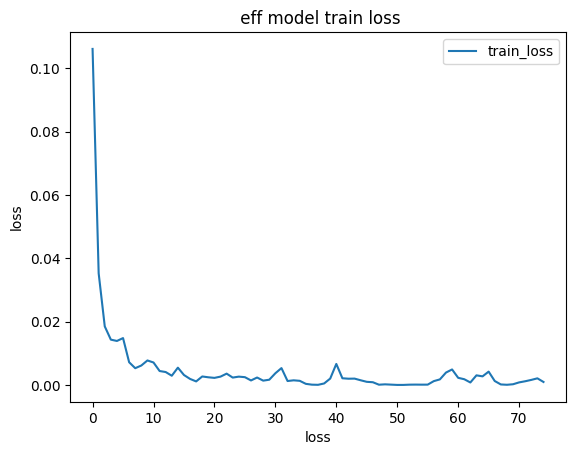

In [17]:
plt.plot(epoch_losses,label="train_loss")
# plt.plot(f1_list,label="f1")
# plt.plot(precision_list,label="precision")
# plt.plot(recall_list,label="recall")
plt.legend()
plt.xlabel("loss")
plt.ylabel("loss")
plt.title(" eff model train loss")
plt.show()

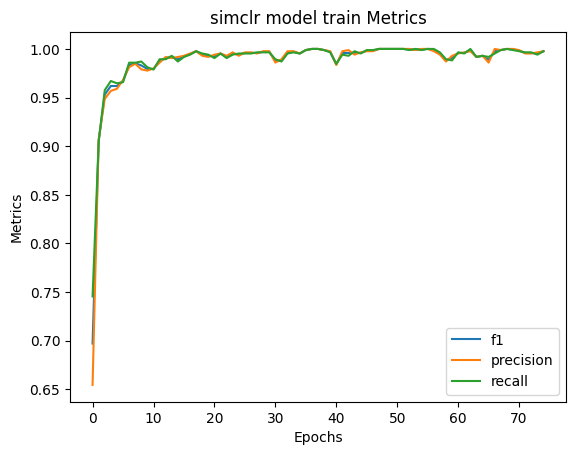

In [18]:
# plt.plot(epoch_losses,label="train_loss")
plt.plot(f1_list,label="f1")
plt.plot(precision_list,label="precision")
plt.plot(recall_list,label="recall")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.title("simclr model train Metrics")
plt.show()

In [19]:
result = predict(classifier,x_test,y_test,nn.CrossEntropyLoss(),128)

100%|██████████| 79/79 [02:31<00:00,  1.92s/it]


In [20]:
df = pd.DataFrame(result,index=[0])
df

,f1,precision,recall,loss
0,0.67381,0.887147,0.543186,"tensor(0.3361, device='cuda:0')"


In [ ]:
epoch_values = [i for i in range(5,31,5)]
test_loss = []
f1_test = []
precision_test = []
recall_test = []
for i in epoch_values:
    model1.load_state_dict(torch.load(f"{path}/imagenet/{i}_delhi_test.pth"))
    result = predict(model1,x_test,y_test,nn.CrossEntropyLoss())
    test_loss.append(result["loss"])
    f1_test.append(result["f1"])
    precision_test.append(result["precision"])
    recall_test.append(result["recall"])


In [ ]:
test_loss[0],f1_test[0],precision_test[0],recall_test[0]

In [ ]:
test_loss = [i.item() for i in test_loss]

In [ ]:
# plot test results
plt.plot(test_loss,label="test_loss")
# plt.plot(f1_test,label="f1")
# plt.plot(precision_test,label="precision")
# plt.plot(recall_test,label="recall")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Imagenet model test loss")
plt.legend()
plt.show()

In [ ]:
# save train and test results and losses
train_results = pd.DataFrame({"train_loss":epoch_losses,"f1":f1_list,"precision":precision_list,"recall":recall_list})
# test_results = pd.DataFrame({"epoch":epoch_values,"test_loss":test_loss,"f1":f1_test,"precision":precision_test,"recall":recall_test})
train_results.to_csv(f"{path}/simclr/train_results_pf.csv",index=False)
# test_results.to_csv(f"{path}/imagenet/test_results_5.csv",index=False)

In [ ]:
csv1 = pd.read_csv(f"{path}/imagenet/train_results.csv")
csv2 = pd.read_csv(f"{path}/imagenet/test_results.csv")

In [ ]:
csv3 = pd.read_csv(f"{path}/simclr/train_results.csv")

In [ ]:
csv3[:10]

In [ ]:
csv1[:10]

In [ ]:
type(csv1.head()["train_loss"][0])

In [ ]:
f1_train = [float(i[7:-2]) for i in csv1["f1"]]
precision_train = [float(i[7:-2]) for i in csv1["precision"]]
recall_train = [float(i[7:-2]) for i in csv1["recall"]]

In [ ]:
plt.plot(f1_test,label="f1")
plt.plot(precision_test,label="precision")
plt.plot(recall_test,label="recall")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("metrics")
plt.title("Test metrics")
plt.show()

In [ ]:
plt.plot(test_loss,label="Test loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Test loss")
plt.show()

In [ ]:
plt.plot(csv2["f1"],label="f1")
plt.plot(csv2["precision"],label="precision")
plt.plot(csv2["recall"],label="recall")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("metrics")
plt.title("Test metrics")
plt.show()

In [ ]:
# Imagenet results
df = pd.read_csv(f"{path}/imagenet/test_results_5.csv")
df[df["epoch"] ==30]

In [ ]:
# Downstream model
eff = torchvision.models.efficientnet_b0(pretrained=False)
class DownstreamModel(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.resnet = nn.Sequential(*list(eff.children())[:-1])
        self.resnet.load_state_dict(torch.load(f"{path}/simsiam/simsiam_bd_100.pt")) # load different weights
        self.fc = nn.Linear(1280,num_classes)

    def forward(self, x):
        x = self.resnet(x).flatten(start_dim=1)
        return self.fc(x)

In [ ]:
classifier1 = DownstreamModel(2).to(device)

In [ ]:
epoch_losses,f1_list,precision_list,recall_list,epoch_k_loss = train(classifier1,x_train,y_train,nn.CrossEntropyLoss(),75,0.001,True,"simsiam",data="delhi_test",k=5)

In [ ]:
torch.save(classifier1.state_dict(),f"{path}/simsiam/simsiam_bd_75_delhi_test_final2.pth")

In [ ]:
result = predict(classifier1,x_test,y_test,nn.CrossEntropyLoss(),128)

In [ ]:
df = pd.DataFrame(result,index=[0])
df